In [149]:
from FNFTpy import nsev
from FNFTpy import nsev_inverse, nsev_inverse_xi_wrapper
import numpy as np
from scipy.integrate import simps, trapz
import pandas as pd
import random
import timeit
import time
from tqdm import tqdm
from scipy.fft import fft, ifft, fftfreq, fftshift, ifftshift
from ssfm import fiber_propogate, get_soliton_pulse, get_gauss_pulse, get_energy
import matplotlib.pyplot as plt
import matplotlib

from prettytable import PrettyTable


import signal_generation as sg
from importlib import reload
reload(sg)

<module 'signal_generation' from '/home/esf0/PycharmProjects/nn_training/signal_generation.py'>

In [122]:
def is_arg_jump(first, second):
    if ((first.imag > 0) & (second.imag < 0) &
            (first.real < 0) & (second.real < 0) ) | ((first.imag < 0) & (second.imag > 0) &
                                                      (first.real < 0) & (second.real < 0) ):
        return 1
    return 0

def get_rect_filled(start, end, n_horizontal, n_vertical):
    step_v = (end.imag - start.imag) / (n_vertical - 1)
    step_h = (end.real - start.real) / (n_horizontal - 1)
    xi = np.zeros(n_vertical * n_horizontal, dtype=complex)
    for i in range(n_vertical):
        for k in range(n_horizontal):
            xi[i * n_horizontal + k] = complex(start.real + step_h * k, start.imag + step_v * i)
    return xi

def get_phase_shift(first, second, result_type=0):
    error = 0
    delta_phi = 0

    if (first.imag >= 0) & (second.imag < 0) & (first.real <= 0) & (second.real <= 0):
        delta_phi = np.angle(second) - np.angle(first) + 2. * np.pi
        error = 1
    elif (first.imag < 0) & (second.imag >= 0) & (first.real <= 0) & (second.real <= 0):
        delta_phi = np.angle(second) - np.angle(first) - 2. * np.pi
        error = -1
    elif (first.imag * second.imag < 0) & (first.real * second.real < 0):
        if result_type == 0:
            error = -10. # I chose -10 cause phase shift can not be more than 2pi
        elif result_type == 1:
            pass
            # TODO: minimal distance
    else:
        delta_phi = np.angle(second) - np.angle(first)


    return delta_phi, error



In [123]:
def get_cauchy(order, a, z, func_values):
    value = np.math.factorial(order) / (2.0j * np.pi) * simps(func_values / np.power(z - a, order + 1), z)
    return value

def get_a_cauchy(point, xi_cont, a_xi):
    return get_cauchy(0, point, xi_cont, a_xi - 1) + 1


def fit_phase_jump(xi_cont, a_xi, first, second, accuracy=1e-4):
    direction = second - first
    a_first = get_a_cauchy(first, xi_cont, a_xi)
    a_second = get_a_cauchy(second, xi_cont, a_xi)

    i = 1
    while abs(second - first) > accuracy:
        middle = first + direction / np.power(2.0, i)
        a_middle = get_a_cauchy(middle, xi_cont, a_xi)

        if is_arg_jump(a_first, a_second) == 1:
            a_second = a_middle
            second = middle
        else:
            a_first = a_middle
            first = middle

        i += 1

        if i >= 100:
            print("[fit_phase_jump]: Error! Number of iterations more than 100")
            break

    return first, second


def get_contour_phase_shift_adaptive(q, t, xi_cont, a_xi):
    total_phase_shift = 0
    error_code = 0
    jump = []

    for i in range(len(a_xi) - 1):
        d_phi, error_phi = get_phase_shift(a_xi[i], a_xi[i + 1])
        if error_phi == -10:
            xi_sub = np.array([xi_cont[i], (xi_cont[i] + xi_cont[i + 1]) / 2., xi_cont[i + 1]])
            # here calc a_xi_sub
            res_sub = nsev(q, t, M=3, Xi1=xi_cont[i], Xi2=xi_cont[i + 1], kappa=1, cst=1, dst=3)
            a_xi_sub = res_sub['cont_a']

            current_phase_shift, error_code_sub, jump_sub = get_contour_phase_shift_adaptive(xi_sub, a_xi_sub)
            for one_jump in jump_sub:
                jump.append(one_jump)

            if error_code_sub == -11:
                print("[get_contour_phase_shift_adaptive] Error: problem in algorithm" )
                error_code = error_code_sub

            d_phi = current_phase_shift
        elif (error_phi == 1) or (error_phi == -1):
            one_jump = {"xi": xi_cont[i], "xi_next": xi_cont[i + 1], "sign": error_phi}
            jump.append(one_jump)


        total_phase_shift += d_phi

    return total_phase_shift, error_code, jump


In [151]:
def find_one_eigenvalue_pjt(q, t, xi_cont, a_xi, xi_first, xi_second):
    eps_stop = 1e-8

    delta_step = np.absolute(xi_first - xi_second)
    line = [xi_first, xi_second]
    a_line = []

    res_temp = nsev(q, t, M=2, Xi1=xi_first, Xi2=xi_second, kappa=1, cst=1, dst=2)
    a_res_temp = res_temp['cont_a']
    a_line.append(a_res_temp[0])
    a_line.append(a_res_temp[1])

    step = complex(0., delta_step)

    end = False
    while not end:

        right_point = line[-1] + step
        left_point = line[-2] + step

        a_right_point = get_a_cauchy(right_point, xi_cont, a_xi)
        a_left_point = get_a_cauchy(left_point, xi_cont, a_xi)

        push = False
        if is_arg_jump(a_left_point, a_right_point) == 1:

            push = True
            step = left_point - line[-2]

        elif is_arg_jump(a_left_point, a_line[-2]) == 1:

            push = True
            step = line[-2] - line[-1]

            right_point = left_point
            left_point = line[-2]
            a_right_point = a_left_point
            a_left_point = a_line[-2]

        elif is_arg_jump(a_right_point, a_line[-1]) == 1:

            push = True
            step = line[-1] - line[-2]

            left_point = right_point
            right_point = line[-1]
            a_left_point = a_right_point
            a_right_point = a_line[-1]

        else:
            if np.absolute(step) < eps_stop:
                print("[find_one_eigenvalue_pjt]: Dest found")
                end = True
            else:
                step /= 2.

            if np.absolute(step) < 1e-10:
                print("[find_one_eigenvalue_pjt] Error: Step less than 10^-10")
                break

        if push:
            line.append(left_point)
            line.append(right_point)
            a_line.append(a_left_point)
            a_line.append(a_right_point)

    left_point, right_point = fit_phase_jump(xi_cont, a_xi, line[-2], line[-1], accuracy=eps_stop)
    line.append(left_point)
    line.append(right_point)

    eigenvalue = ( line[-1] + line[-2]) / 2.
    return eigenvalue


def find_spectrum_pjt(q, t, xi_cont, a_xi):
    print("--------------- start PJT ---------------")

    spectrum = []
    time_found = []
    total_phase_shift, error_code, jump = get_contour_phase_shift_adaptive(q, t, xi_cont, a_xi)
    if error_code != 0:
        print("[find_spectrum_pjt] Error: problem with jump localisation")
        return -1
    total_discr = round(total_phase_shift / (2. * np.pi))
    n_jump = len(jump)
    print("Number of discrete eigenvalues:", total_discr)
    print("Number of jumps:", n_jump)
    if n_jump != total_discr:
        print("[find_spectrum_pjt] Error: problem with jump cleaning")
        return -2

    for i in range(n_jump):
        t_start = time.time()
        spectrum.append(find_one_eigenvalue_pjt(q, t, xi_cont, a_xi, jump[i]['xi'], jump[i]['xi_next']))
        t_end = time.time()
        time_found.append(t_end - t_start)

    print("--------------- end PJT ---------------")

    table = PrettyTable()
    table.field_names = ["n", "eigenvalue", "time, s"]

    soliton_energy = 0.0
    for i in range(len(spectrum)):
        table.add_row([i, spectrum[i], time_found[i]])
        soliton_energy += 4. * spectrum[i].imag

    table.add_row(["-", "-", "-"])
    table.add_row(["E", soliton_energy, ""])

    print(table)

    return spectrum

In [141]:
D = 2048 * 16
M = D * 2
Tmax = 15
tvec = np.linspace(-Tmax, Tmax, D)
# calculate suitable frequency bonds (xi)
rv, xi = nsev_inverse_xi_wrapper(D, tvec[0], tvec[-1], M)

xi[0] = xi[0]
xi[1] = xi[1]

xivec = xi[0] + np.arange(M) * (xi[1] - xi[0]) / (M - 1)

temp_a = np.pi / (2. * Tmax) * (D-1)
print(temp_a, temp_a - temp_a / M)
print(xi[1] - xi[0])

# analytic field: chirp-free N=2.2 Satsuma-Yajima pulse
q = 26.2 / np.cosh(tvec)

# semi-analytic nonlinear spectrum
bound_states = np.array([0.7j, 1.7j])
disc_norming_const_ana = [1.0, -1.0]
cont_b_ana = 0.587783 / np.cosh(xivec * np.pi) * np.exp(1.0j * np.pi)

# call the function
res = nsev_inverse(xivec, tvec, cont_b_ana, bound_states, disc_norming_const_ana, cst=1, dst=0)

# compare result to analytic function
print("\n\nnsev-inverse example: Satsuma-Yajima N=2.2")
print("Difference analytic - numeric: sum((q_ana-q_num)**2) = %.2e  (should be approx 0) "%np.sum(np.abs(q-res['q'])**2))


3431.3522160058915 3431.2998577262283
3431.2998577262288


<ipython-input-141-7ae518020c6a>:23: RuntimeWarning: overflow encountered in cosh
  cont_b_ana = 0.587783 / np.cosh(xivec * np.pi) * np.exp(1.0j * np.pi)




nsev-inverse example: Satsuma-Yajima N=2.2
Difference analytic - numeric: sum((q_ana-q_num)**2) = 1.26e+06  (should be approx 0) 


In (2.069304918659117+19.26846889476445j) a = (0.1196813971940538-1.2159635714554836e-05j)
In (1.9831160815420392+16.96911249238264j) a = (0.11966774961602622-1.1732105757446346e-05j)
In (1.729191506527505+21.54887249500599j) a = (0.1196948203865168-1.0078147777957656e-05j)
In (1.5618538670639777+14.80372917375693j) a = (0.11965479670734058-9.28367728755213e-06j)
In (0.9684087607236093+23.56937392877547j) a = (0.11970662510161356-5.578334882793617e-06j)
In (0.9173275606882887+12.84212747846821j) a = (0.1196429852943306-5.450372300359658e-06j)
In (0.1096752557861686+11.066013553169208j) a = (0.11963223481020513-5.797117282266188e-07j)
In (0.05787245495893999+9.694558718325094j) a = (0.11962389851336275-2.652855041164509e-07j)
In (-0.06804398756185381+24.89585072386151j) a = (0.11971433830154499+4.6364752021469157e-07j)
In (-1.126643965317153e-42+0.6999999993454052j) a = (0.1195683531170284+9.834066128597748e-08j)
In (-4.584427968206921e-37+1.6999999961460648j) a = (0.11957460349514237+9

<ipython-input-142-fb674d11c568>:38: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


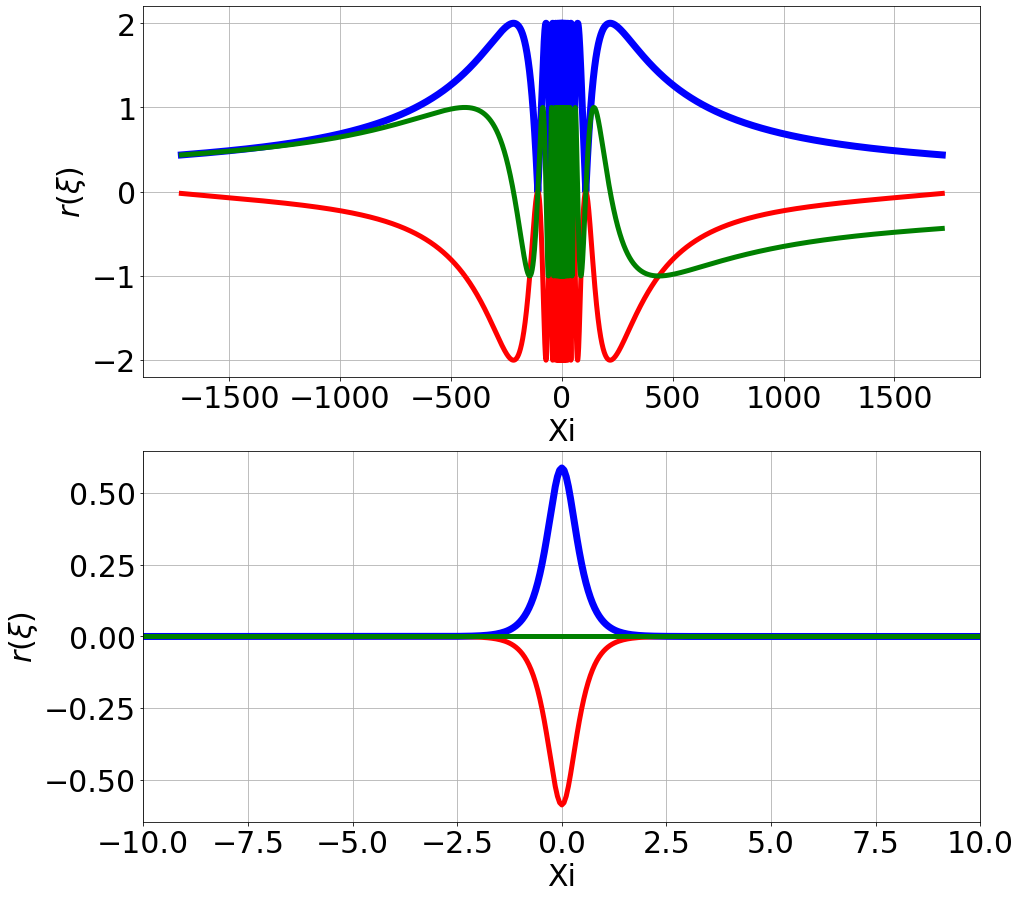

In [142]:
res = nsev(q, tvec, M=M, Xi1=xi[0], Xi2=xi[-1], kappa=1, cst=1, dst=2)


cont_a = res['cont_a']
cont_b = res['cont_b']

discr_spec = res['bound_states']
for dp in discr_spec:
    print("In", dp, "a =", get_cauchy(0, dp, xivec, cont_a - 1) + 1)

print(res['bound_states'])
print(res['disc_res'])
print(res['disc_norm'])
print(get_cauchy(0, 1.7j, xivec, cont_a - 1))
b_p = get_cauchy(0, 1.7j, xivec, cont_b)
ad_p = get_cauchy(1, 1.7j, xivec, cont_a - 1)
print(b_p, ad_p, b_p / ad_p)

matplotlib.rcParams.update({'font.size': 30})

fig, axs = plt.subplots(2, 1, figsize=(15, 15))
axs[0].plot(xivec, np.absolute(cont_a - 1), 'blue', lw=7)
axs[0].plot(xivec, np.real(cont_a - 1), 'red', lw=5)
axs[0].plot(xivec, np.imag(cont_a - 1), 'green', lw=5)
# axs[0].set_xlim(plt_t[0], plt_t[-1])
axs[0].set_xlabel('Xi')
axs[0].set_ylabel(r'$r(\xi)$')
axs[0].grid(True)

axs[1].plot(xivec, np.absolute(cont_b), 'blue', lw=7)
axs[1].plot(xivec, np.real(cont_b), 'red', lw=5)
axs[1].plot(xivec, np.imag(cont_b), 'green', lw=5)
axs[1].set_xlim(-10, 10)
axs[1].set_xlabel('Xi')
axs[1].set_ylabel(r'$r(\xi)$')
axs[1].grid(True)

fig.show()

In [143]:
n_vert, n_hor = 2**5, 2**10
a_map = np.zeros(n_vert * n_hor, dtype=complex)

real_min = -5
real_max = 5
imag_min = 0
imag_max = 10

xi_map = get_rect_filled(real_min + 1.0j * imag_min, real_max + 1.0j * imag_max, n_hor, n_vert)
for i in range(len(xi_map)):
    a_map[i] = get_cauchy(0, xi_map[i], xivec, cont_a - 1)

a_phase = np.angle(a_map + 1)

<ipython-input-128-98facd494ebd>:23: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


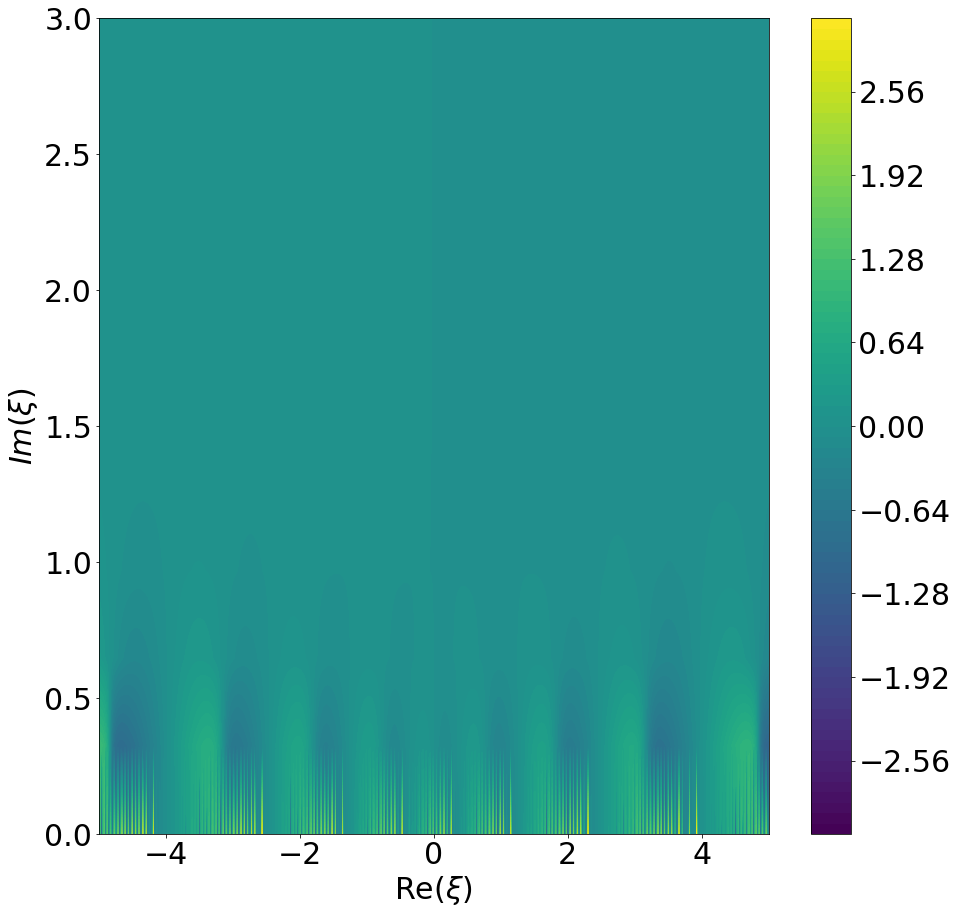

In [128]:
x = np.linspace(real_min, real_max, n_hor)
y = np.linspace(imag_min, imag_max, n_vert)
X, Y = np.meshgrid(x, y)
Z = a_phase.reshape(X.shape)

matplotlib.rcParams.update({'font.size': 30})

fig, axs = plt.subplots(1, 1, figsize=(15, 15))

levels = 100
cset = axs.contourf(X, Y, Z, levels = levels, cmap=plt.cm.viridis)
fig.colorbar(cset, shrink=1, aspect=20)
# axs.grid(True)
# axs.set_xlim(-1, 1)
axs.set_ylim(0, 3)
axs.set_xlabel(r'Re($\xi$)')
axs.set_ylabel(r'$Im(\xi)$')

# axs.plot(xivec, np.absolute(cont_a - 1), 'blue', lw=7)
# axs[0].plot(xivec, np.real(cont_a - 1), 'red', lw=5)
# axs[0].plot(xivec, np.imag(cont_a - 1), 'green', lw=5)

fig.show()

In [146]:
ind_top, ind_bot = 7, 6
m_temp = ind_top - ind_bot + 1

res_temp = nsev(q, tvec, M=m_temp, Xi1=xivec[ind_bot], Xi2=xivec[ind_top], kappa=1, cst=1, dst=2)
print(res_temp['cont_a'])
print(cont_a[ind_bot:ind_top + 1])

[0.97949464+0.4363044j 0.97948224+0.4363146j]
[0.97949464+0.4363044j 0.97948224+0.4363146j]


In [152]:
temp_test = get_contour_phase_shift_adaptive(q, tvec, xivec, cont_a)
print(temp_test)
print(temp_test[0] / (2 * np.pi))
print(len(res['bound_states']))

find_spectrum_pjt(q, tvec, xivec, cont_a)

(162.52488421243032, 0, [{'xi': -218.01987651746435, 'xi_next': -217.9675182378012, 'sign': 1}, {'xi': -71.31197690124577, 'xi_next': -71.25961862158238, 'sign': 1}, {'xi': -41.153607815256464, 'xi_next': -41.1012495355933, 'sign': 1}, {'xi': -27.74988822148339, 'xi_next': -27.69752994182022, 'sign': 1}, {'xi': -19.896146272007172, 'xi_next': -19.843787992343778, 'sign': 1}, {'xi': -14.71267658535271, 'xi_next': -14.660318305689543, 'sign': 1}, {'xi': -10.890522169940823, 'xi_next': -10.838163890277656, 'sign': 1}, {'xi': -8.010816788466173, 'xi_next': -7.958458508802778, 'sign': 1}, {'xi': -5.759410762949528, 'xi_next': -5.7070524832865885, 'sign': 1}, {'xi': -3.926870974738449, 'xi_next': -3.874512695075282, 'sign': 1}, {'xi': -2.4608391441695403, 'xi_next': -2.4084808645061457, 'sign': 1}, {'xi': -1.2565987119164674, 'xi_next': -1.2042404322533002, 'sign': 1}, {'xi': -0.41886623730556494, 'xi_next': -0.36650795764239774, 'sign': 1}, {'xi': 0.366507957641943, 'xi_next': 0.41886623730

<ipython-input-123-968c7917a4e0>:2: RuntimeWarning: divide by zero encountered in true_divide
  value = np.math.factorial(order) / (2.0j * np.pi) * simps(func_values / np.power(z - a, order + 1), z)
/home/esf0/.conda/envs/nn_training/lib/python3.8/site-packages/scipy/integrate/_quadrature.py:374: RuntimeWarning: invalid value encountered in multiply
  y[slice1]*hsum*hsum/hprod +
/home/esf0/.conda/envs/nn_training/lib/python3.8/site-packages/scipy/integrate/_quadrature.py:373: RuntimeWarning: invalid value encountered in multiply
  tmp = hsum/6.0 * (y[slice0]*(2-1.0/h0divh1) +
/home/esf0/.conda/envs/nn_training/lib/python3.8/site-packages/scipy/integrate/_quadrature.py:375: RuntimeWarning: invalid value encountered in multiply
  y[slice2]*(2-h0divh1))


[find_one_eigenvalue_pjt]: Dest found
[find_one_eigenvalue_pjt]: Dest found
[find_one_eigenvalue_pjt]: Dest found
[find_one_eigenvalue_pjt]: Dest found
[find_one_eigenvalue_pjt]: Dest found
[find_one_eigenvalue_pjt]: Dest found
[find_one_eigenvalue_pjt]: Dest found
[find_one_eigenvalue_pjt]: Dest found
[find_one_eigenvalue_pjt]: Dest found
[find_one_eigenvalue_pjt]: Dest found
[find_one_eigenvalue_pjt]: Dest found
[find_one_eigenvalue_pjt]: Dest found
[find_one_eigenvalue_pjt]: Dest found
[find_one_eigenvalue_pjt]: Dest found
[find_one_eigenvalue_pjt]: Dest found
[find_one_eigenvalue_pjt]: Dest found
[find_one_eigenvalue_pjt]: Dest found
[find_one_eigenvalue_pjt]: Dest found
[find_one_eigenvalue_pjt]: Dest found
[find_one_eigenvalue_pjt]: Dest found
[find_one_eigenvalue_pjt]: Dest found
[find_one_eigenvalue_pjt]: Dest found
[find_one_eigenvalue_pjt]: Dest found
[find_one_eigenvalue_pjt]: Dest found
[find_one_eigenvalue_pjt]: Dest found
[find_one_eigenvalue_pjt]: Dest found
------------

[(-217.94136466041505+0.002009917881147039j),
 (-67.7450691022978+15.929089166993538j),
 (-40.35514405351396+6.120733741636711j),
 (-27.42264897670939+3.2901955565829226j),
 (-19.765250575969482+2.098578072738325j),
 (-14.59487045923138+1.472986294987371j),
 (-10.831619108440556+1.099483745723052j),
 (-7.955186119444612+0.8532366735638299j),
 (-5.6939629164916505+0.6812960195414677j),
 (-3.8712403057171305+0.5446820784241122j),
 (-2.40520847514798+0.43463088546276246j),
 (-1.2435091451214721+0.33964981359800256j),
 (-0.35996317580529846+0.2347890797075523j),
 (0.3403288146894491+0.2347890797085719j),
 (1.2304195689635187+0.3396498135965276j),
 (2.3823017215535383+0.43463089170246844j),
 (3.848333552122447+0.5446820971488922j),
 (5.680873340333527+0.6812960569939863j),
 (7.932279365850171+0.8532367422176512j),
 (10.811984747324821+1.0994838643133247j),
 (14.581780883073883+1.4729865009535539j),
 (19.745616214853662+2.0985784784418904j),
 (27.40955940055155+3.2901964491307676j),
 (40.342

In [155]:
print("FNFT discr", len(discr_spec))
print(discr_spec)

FNFT discr 26
[ 2.06930492e+00+19.26846889j  1.98311608e+00+16.96911249j
  1.72919151e+00+21.5488725j   1.56185387e+00+14.80372917j
  9.68408761e-01+23.56937393j  9.17327561e-01+12.84212748j
  1.09675256e-01+11.06601355j  5.78724550e-02 +9.69455872j
 -6.80439876e-02+24.89585072j -1.12664397e-42 +0.7j
 -4.58442797e-37 +1.7j        -5.47686328e-34 +2.69999999j
  2.62736169e-02 +8.69217521j -1.06003184e-30 +3.69999998j
 -1.50463277e-34 +4.69999997j  5.00741786e-33 +5.69999996j
 -4.43734259e-31 +7.69999992j -3.44612486e-04 +9.69988592j
  1.29520558e-01+24.87851345j -9.71190286e-02+11.14865041j
 -9.10916232e-01+12.89057574j -9.51687055e-01+23.60450047j
 -1.55776341e+00+14.84170909j -1.98330420e+00+17.00527009j
 -1.72085699e+00+21.59014911j -2.06854885e+00+19.30832157j]
